# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large" #"anferico/bert-for-patents"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=5
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.9.1
Found existing installation: transformers 4.16.2
Uninstalling transformers-4.16.2:
  Successfully uninstalled transformers-4.16.2


Found existing installation: tokenizers 0.11.6
Uninstalling tokenizers-0.11.6:
  Successfully uninstalled tokenizers-0.11.6


Looking in links: ../input/pppm-pip-wheels
Processing /kaggle/input/pppm-pip-wheels/transformers-4.18.0-py3-none-any.whl
Processing /kaggle/input/pppm-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.1 requires transformers<4.17,>=4.1, but you have transformers 4.18.0 which is incompatible.


Looking in links: ../input/pppm-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] #+ '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] #+ '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network


# EDA

<AxesSubplot:>

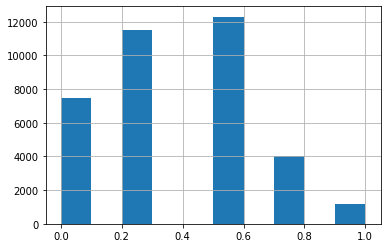

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target']) + 3 + 3 # make even 50
#                 + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 50


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [16]:
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)


{'input_ids': tensor([    1, 47284,     2, 47284,   265,  6435,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])}
tensor(0.5000)


# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [20]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 1s (remain 47m 55s) Loss: 0.6898(0.6898) Grad: 145944.5156  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 50s (remain 13m 27s) Loss: 0.6255(0.6245) Grad: 44408.7422  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 1m 39s (remain 12m 28s) Loss: 0.6187(0.6088) Grad: 29111.6113  LR: 0.00001997  
Epoch: [1][300/1709] Elapsed 2m 28s (remain 11m 36s) Loss: 0.5705(0.6038) Grad: 12246.6934  LR: 0.00001994  
Epoch: [1][400/1709] Elapsed 3m 18s (remain 10m 45s) Loss: 0.5949(0.5935) Grad: 18309.5918  LR: 0.00001989  
Epoch: [1][500/1709] Elapsed 4m 7s (remain 9m 56s) Loss: 0.5936(0.5853) Grad: 26060.9883  LR: 0.00001983  
Epoch: [1][600/1709] Elapsed 4m 56s (remain 9m 6s) Loss: 0.5832(0.5820) Grad: 10768.1719  LR: 0.00001976  
Epoch: [1][700/1709] Elapsed 5m 45s (remain 8m 17s) Loss: 0.5929(0.5803) Grad: 8888.6094  LR: 0.00001967  
Epoch: [1][800/1709] Elapsed 6m 34s (remain 7m 27s) Loss: 0.4627(0.5783) Grad: 16340.6807  LR: 0.00001957  
Epoch: [1][900/1709] Elapsed

Epoch 1 - avg_train_loss: 0.5628  avg_val_loss: 0.5407  time: 910s
Epoch 1 - Score: 0.8288
Epoch 1 - Save Best Score: 0.8288 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5042(0.5407) 
Epoch: [2][0/1709] Elapsed 0m 0s (remain 25m 4s) Loss: 0.5277(0.5277) Grad: 196171.2500  LR: 0.00001809  
Epoch: [2][100/1709] Elapsed 0m 50s (remain 13m 17s) Loss: 0.5844(0.5314) Grad: 76213.5703  LR: 0.00001787  
Epoch: [2][200/1709] Elapsed 1m 39s (remain 12m 24s) Loss: 0.4329(0.5306) Grad: 65473.9453  LR: 0.00001764  
Epoch: [2][300/1709] Elapsed 2m 28s (remain 11m 34s) Loss: 0.4809(0.5325) Grad: 78531.9219  LR: 0.00001739  
Epoch: [2][400/1709] Elapsed 3m 17s (remain 10m 45s) Loss: 0.5189(0.5297) Grad: 47559.2891  LR: 0.00001714  
Epoch: [2][500/1709] Elapsed 4m 7s (remain 9m 55s) Loss: 0.4671(0.5287) Grad: 46886.5234  LR: 0.00001688  
Epoch: [2][600/1709] Elapsed 4m 56s (remain 9m 5s) Loss: 0.6024(0.5271) Grad: 128018.8125  LR: 0.00001661  
Epoch: [2][700/1709] Elapsed 5m 45s (remain 8m 16s) Loss: 0.5812(0.5261) Grad: 58365.4336  LR: 0.00001633  
Epoch: [2][800/1709] Elapsed 6m 34s (remain 7m 26s) Loss: 0.5524(0.5

Epoch 2 - avg_train_loss: 0.5207  avg_val_loss: 0.5470  time: 909s
Epoch 2 - Score: 0.8430
Epoch 2 - Save Best Score: 0.8430 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4975(0.5470) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 20m 6s) Loss: 0.5284(0.5284) Grad: 189452.8281  LR: 0.00001309  
Epoch: [3][100/1709] Elapsed 0m 49s (remain 13m 13s) Loss: 0.5279(0.5115) Grad: 43890.0898  LR: 0.00001274  
Epoch: [3][200/1709] Elapsed 1m 39s (remain 12m 23s) Loss: 0.6231(0.5077) Grad: 79687.8672  LR: 0.00001238  
Epoch: [3][300/1709] Elapsed 2m 28s (remain 11m 33s) Loss: 0.5757(0.5084) Grad: 40554.8516  LR: 0.00001203  
Epoch: [3][400/1709] Elapsed 3m 17s (remain 10m 43s) Loss: 0.4688(0.5114) Grad: 85289.1641  LR: 0.00001166  
Epoch: [3][500/1709] Elapsed 4m 6s (remain 9m 53s) Loss: 0.4912(0.5103) Grad: 96200.1250  LR: 0.00001130  
Epoch: [3][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.4344(0.5093) Grad: 45340.0508  LR: 0.00001094  
Epoch: [3][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.3954(0.5090) Grad: 78547.6641  LR: 0.00001057  
Epoch: [3][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.4440(0.50

Epoch 3 - avg_train_loss: 0.5108  avg_val_loss: 0.5455  time: 909s
Epoch 3 - Score: 0.8503
Epoch 3 - Save Best Score: 0.8503 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4990(0.5455) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 20m 13s) Loss: 0.4951(0.4951) Grad: 88766.4062  LR: 0.00000691  
Epoch: [4][100/1709] Elapsed 0m 49s (remain 13m 12s) Loss: 0.5322(0.4953) Grad: 48653.2734  LR: 0.00000657  
Epoch: [4][200/1709] Elapsed 1m 38s (remain 12m 21s) Loss: 0.5114(0.5031) Grad: 89929.2656  LR: 0.00000622  
Epoch: [4][300/1709] Elapsed 2m 27s (remain 11m 31s) Loss: 0.4212(0.5003) Grad: 36142.6758  LR: 0.00000588  
Epoch: [4][400/1709] Elapsed 3m 16s (remain 10m 42s) Loss: 0.5886(0.5009) Grad: 212921.0156  LR: 0.00000555  
Epoch: [4][500/1709] Elapsed 4m 6s (remain 9m 53s) Loss: 0.5915(0.4995) Grad: 200541.8906  LR: 0.00000523  
Epoch: [4][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.5956(0.5020) Grad: 65155.5000  LR: 0.00000491  
Epoch: [4][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.5078(0.5023) Grad: 103459.4062  LR: 0.00000459  
Epoch: [4][800/1709] Elapsed 6m 33s (remain 7m 25s) Loss: 0.5297(0

Epoch 4 - avg_train_loss: 0.5034  avg_val_loss: 0.5484  time: 909s
Epoch 4 - Score: 0.8505
Epoch 4 - Save Best Score: 0.8505 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4935(0.5484) 
Epoch: [5][0/1709] Elapsed 0m 0s (remain 19m 56s) Loss: 0.5868(0.5868) Grad: 37131.0078  LR: 0.00000191  
Epoch: [5][100/1709] Elapsed 0m 49s (remain 13m 12s) Loss: 0.4862(0.5044) Grad: 40037.0703  LR: 0.00000170  
Epoch: [5][200/1709] Elapsed 1m 38s (remain 12m 22s) Loss: 0.5017(0.4946) Grad: 44273.2070  LR: 0.00000150  
Epoch: [5][300/1709] Elapsed 2m 27s (remain 11m 31s) Loss: 0.5655(0.4979) Grad: 138796.3281  LR: 0.00000131  
Epoch: [5][400/1709] Elapsed 3m 16s (remain 10m 42s) Loss: 0.4122(0.4964) Grad: 108225.4219  LR: 0.00000114  
Epoch: [5][500/1709] Elapsed 4m 5s (remain 9m 52s) Loss: 0.3434(0.4951) Grad: 103809.4766  LR: 0.00000097  
Epoch: [5][600/1709] Elapsed 4m 54s (remain 9m 3s) Loss: 0.5714(0.4949) Grad: 256429.7500  LR: 0.00000082  
Epoch: [5][700/1709] Elapsed 5m 44s (remain 8m 14s) Loss: 0.4258(0.4951) Grad: 69085.9297  LR: 0.00000068  
Epoch: [5][800/1709] Elapsed 6m 33s (remain 7m 25s) Loss: 0.3916(

Epoch 5 - avg_train_loss: 0.4988  avg_val_loss: 0.5510  time: 908s
Epoch 5 - Score: 0.8500


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4981(0.5510) 


========== fold: 0 result ==========
Score: 0.8505
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1709] Elapsed 0m 0s (remain 18m 37s) Loss: 0.9039(0.9039) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 49s (remain 13m 9s) Loss: 0.5937(0.6628) Grad: 10276.2129  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 1m 38s (remain 12m 21s) Loss: 0.6226(0.6561) Grad: 35678.7383  LR: 0.00001997  
Epoch: [1][300/1709] Elapsed 2m 27s (remain 11m 31s) Loss: 0.6267(0.6518) Grad: 10845.7998  LR: 0.00001994  
Epoch: [1][400/1709] Elapsed 3m 16s (remain 10m 42s) Loss: 0.6306(0.6512) Grad: 22098.3730  LR: 0.00001989  
Epoch: [1][500/1709] Elapsed 4m 5s (remain 9m 53s) Loss: 0.6367(0.6511) Grad: 5369.8770  LR: 0.00001983  
Epoch: [1][600/1709] Elapsed 4m 54s (remain 9m 3s) Loss: 0.6502(0.6514) Grad: 6376.4966  LR: 0.00001976  
Epoch: [1][700/1709] Elapsed 5m 44s (remain 8m 14s) Loss: 0.6573(0.6509) Grad: 6981.3848  LR: 0.00001967  
Epoch: [1][800/1709] Elapsed 6m 33s (remain 7m 25s) Loss: 0.6307(0.6511) Grad: 5413.3003  LR: 0.00001957  
Epoch: [1][900/1709] Elapsed 7m 22s (rem

Epoch 1 - avg_train_loss: 0.6533  avg_val_loss: 0.6503  time: 908s
Epoch 1 - Score: 0.1884
Epoch 1 - Save Best Score: 0.1884 Model


EVAL: [569/570] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6219(0.6503) 
Epoch: [2][0/1709] Elapsed 0m 1s (remain 30m 43s) Loss: 0.7023(0.7023) Grad: 79017.4766  LR: 0.00001809  
Epoch: [2][100/1709] Elapsed 0m 50s (remain 13m 18s) Loss: 0.6436(0.6481) Grad: 20030.0918  LR: 0.00001787  
Epoch: [2][200/1709] Elapsed 1m 39s (remain 12m 24s) Loss: 0.6674(0.6462) Grad: 29019.1875  LR: 0.00001764  
Epoch: [2][300/1709] Elapsed 2m 28s (remain 11m 33s) Loss: 0.6382(0.6474) Grad: 10594.1953  LR: 0.00001739  
Epoch: [2][400/1709] Elapsed 3m 17s (remain 10m 43s) Loss: 0.6399(0.6491) Grad: 9216.5781  LR: 0.00001714  
Epoch: [2][500/1709] Elapsed 4m 6s (remain 9m 54s) Loss: 0.6593(0.6480) Grad: 8586.5059  LR: 0.00001688  
Epoch: [2][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.6064(0.6479) Grad: 4814.2812  LR: 0.00001661  
Epoch: [2][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.6257(0.6472) Grad: 3864.8389  LR: 0.00001633  
Epoch: [2][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.5657(0.6460) 

Epoch 2 - avg_train_loss: 0.6122  avg_val_loss: 0.5797  time: 908s
Epoch 2 - Score: 0.6982
Epoch 2 - Save Best Score: 0.6982 Model


EVAL: [569/570] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5561(0.5797) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 22m 0s) Loss: 0.4112(0.4112) Grad: 1045484.8125  LR: 0.00001309  
Epoch: [3][100/1709] Elapsed 0m 50s (remain 13m 16s) Loss: 0.4177(0.5428) Grad: 19162.5410  LR: 0.00001274  
Epoch: [3][200/1709] Elapsed 1m 38s (remain 12m 22s) Loss: 0.5877(0.5453) Grad: 26422.0977  LR: 0.00001238  
Epoch: [3][300/1709] Elapsed 2m 27s (remain 11m 31s) Loss: 0.5163(0.5475) Grad: 22263.5098  LR: 0.00001203  
Epoch: [3][400/1709] Elapsed 3m 16s (remain 10m 42s) Loss: 0.5634(0.5438) Grad: 14038.2969  LR: 0.00001166  
Epoch: [3][500/1709] Elapsed 4m 5s (remain 9m 52s) Loss: 0.4581(0.5447) Grad: 26461.1445  LR: 0.00001130  
Epoch: [3][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.5660(0.5434) Grad: 17324.2793  LR: 0.00001094  
Epoch: [3][700/1709] Elapsed 5m 44s (remain 8m 14s) Loss: 0.5919(0.5426) Grad: 76007.4844  LR: 0.00001057  
Epoch: [3][800/1709] Elapsed 6m 33s (remain 7m 25s) Loss: 0.5307(0.5

Epoch 3 - avg_train_loss: 0.5391  avg_val_loss: 0.5385  time: 908s
Epoch 3 - Score: 0.8403
Epoch 3 - Save Best Score: 0.8403 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4131(0.5385) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 21m 10s) Loss: 0.5388(0.5388) Grad: 55141.3203  LR: 0.00000691  
Epoch: [4][100/1709] Elapsed 0m 49s (remain 13m 14s) Loss: 0.5997(0.5281) Grad: 81649.5625  LR: 0.00000657  
Epoch: [4][200/1709] Elapsed 1m 38s (remain 12m 22s) Loss: 0.5584(0.5271) Grad: 70626.7656  LR: 0.00000622  
Epoch: [4][300/1709] Elapsed 2m 28s (remain 11m 32s) Loss: 0.5727(0.5256) Grad: 92378.7266  LR: 0.00000588  
Epoch: [4][400/1709] Elapsed 3m 17s (remain 10m 43s) Loss: 0.5688(0.5252) Grad: 54326.4805  LR: 0.00000555  
Epoch: [4][500/1709] Elapsed 4m 6s (remain 9m 53s) Loss: 0.3526(0.5217) Grad: 64207.3867  LR: 0.00000523  
Epoch: [4][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.5106(0.5205) Grad: 96718.8906  LR: 0.00000491  
Epoch: [4][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.5239(0.5211) Grad: 86866.2812  LR: 0.00000459  
Epoch: [4][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.6175(0.52

Epoch 4 - avg_train_loss: 0.5174  avg_val_loss: 0.5466  time: 909s
Epoch 4 - Score: 0.8419
Epoch 4 - Save Best Score: 0.8419 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4198(0.5466) 
Epoch: [5][0/1709] Elapsed 0m 0s (remain 21m 24s) Loss: 0.5640(0.5640) Grad: 84788.2266  LR: 0.00000191  
Epoch: [5][100/1709] Elapsed 0m 49s (remain 13m 15s) Loss: 0.4256(0.5135) Grad: 58806.0000  LR: 0.00000170  
Epoch: [5][200/1709] Elapsed 1m 38s (remain 12m 22s) Loss: 0.4916(0.5140) Grad: 85160.7656  LR: 0.00000150  
Epoch: [5][300/1709] Elapsed 2m 28s (remain 11m 32s) Loss: 0.4833(0.5138) Grad: 71923.4375  LR: 0.00000131  
Epoch: [5][400/1709] Elapsed 3m 17s (remain 10m 42s) Loss: 0.5849(0.5116) Grad: 41928.8516  LR: 0.00000114  
Epoch: [5][500/1709] Elapsed 4m 6s (remain 9m 53s) Loss: 0.4771(0.5129) Grad: 66039.9922  LR: 0.00000097  
Epoch: [5][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.6406(0.5121) Grad: 53368.9922  LR: 0.00000082  
Epoch: [5][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.6119(0.5120) Grad: 25859.6504  LR: 0.00000068  
Epoch: [5][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.6429(0.51

Epoch 5 - avg_train_loss: 0.5135  avg_val_loss: 0.5499  time: 910s
Epoch 5 - Score: 0.8419


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4243(0.5499) 


========== fold: 1 result ==========
Score: 0.8419
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1709] Elapsed 0m 0s (remain 22m 6s) Loss: 0.6583(0.6583) Grad: 155173.2812  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 49s (remain 13m 14s) Loss: 0.5062(0.6136) Grad: 32113.4258  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 1m 39s (remain 12m 23s) Loss: 0.7003(0.6045) Grad: 117835.9375  LR: 0.00001997  
Epoch: [1][300/1709] Elapsed 2m 28s (remain 11m 33s) Loss: 0.6844(0.5937) Grad: 30822.1797  LR: 0.00001994  
Epoch: [1][400/1709] Elapsed 3m 17s (remain 10m 44s) Loss: 0.5140(0.5868) Grad: 42154.0664  LR: 0.00001989  
Epoch: [1][500/1709] Elapsed 4m 6s (remain 9m 55s) Loss: 0.5078(0.5825) Grad: 25921.4922  LR: 0.00001983  
Epoch: [1][600/1709] Elapsed 4m 56s (remain 9m 5s) Loss: 0.5801(0.5777) Grad: 21280.5273  LR: 0.00001976  
Epoch: [1][700/1709] Elapsed 5m 45s (remain 8m 16s) Loss: 0.5190(0.5752) Grad: 30749.8867  LR: 0.00001967  
Epoch: [1][800/1709] Elapsed 6m 34s (remain 7m 27s) Loss: 0.5119(0.5732) Grad: 15311.2549  LR: 0.00001957  
Epoch: [1][900/1709] Elapse

Epoch 1 - avg_train_loss: 0.5602  avg_val_loss: 0.5535  time: 911s
Epoch 1 - Score: 0.8141
Epoch 1 - Save Best Score: 0.8141 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4759(0.5535) 
Epoch: [2][0/1709] Elapsed 0m 0s (remain 21m 39s) Loss: 0.5265(0.5265) Grad: 135183.7812  LR: 0.00001809  
Epoch: [2][100/1709] Elapsed 0m 50s (remain 13m 17s) Loss: 0.5127(0.5281) Grad: 71212.8516  LR: 0.00001787  
Epoch: [2][200/1709] Elapsed 1m 39s (remain 12m 24s) Loss: 0.5952(0.5287) Grad: 74814.8984  LR: 0.00001764  
Epoch: [2][300/1709] Elapsed 2m 28s (remain 11m 33s) Loss: 0.4524(0.5265) Grad: 158926.0156  LR: 0.00001739  
Epoch: [2][400/1709] Elapsed 3m 17s (remain 10m 43s) Loss: 0.5943(0.5275) Grad: 35754.5273  LR: 0.00001714  
Epoch: [2][500/1709] Elapsed 4m 6s (remain 9m 54s) Loss: 0.4384(0.5254) Grad: 100890.6875  LR: 0.00001688  
Epoch: [2][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.5534(0.5258) Grad: 70935.0391  LR: 0.00001661  
Epoch: [2][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.4944(0.5247) Grad: 15092.8008  LR: 0.00001633  
Epoch: [2][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.5275(0

Epoch 2 - avg_train_loss: 0.5234  avg_val_loss: 0.5475  time: 910s
Epoch 2 - Score: 0.8347
Epoch 2 - Save Best Score: 0.8347 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4907(0.5475) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 21m 25s) Loss: 0.3877(0.3877) Grad: 198506.3281  LR: 0.00001309  
Epoch: [3][100/1709] Elapsed 0m 49s (remain 13m 14s) Loss: 0.5214(0.5171) Grad: 74648.8359  LR: 0.00001274  
Epoch: [3][200/1709] Elapsed 1m 39s (remain 12m 23s) Loss: 0.4972(0.5123) Grad: 205864.7188  LR: 0.00001238  
Epoch: [3][300/1709] Elapsed 2m 28s (remain 11m 33s) Loss: 0.4379(0.5082) Grad: 53456.2930  LR: 0.00001203  
Epoch: [3][400/1709] Elapsed 3m 17s (remain 10m 43s) Loss: 0.4740(0.5111) Grad: 104952.5078  LR: 0.00001166  
Epoch: [3][500/1709] Elapsed 4m 6s (remain 9m 54s) Loss: 0.5258(0.5088) Grad: 97860.1875  LR: 0.00001130  
Epoch: [3][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.6545(0.5088) Grad: 153140.5781  LR: 0.00001094  
Epoch: [3][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.3737(0.5076) Grad: 42999.7773  LR: 0.00001057  
Epoch: [3][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.4867(

Epoch 3 - avg_train_loss: 0.5069  avg_val_loss: 0.5525  time: 910s
Epoch 3 - Score: 0.8426
Epoch 3 - Save Best Score: 0.8426 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4982(0.5525) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 22m 0s) Loss: 0.4580(0.4580) Grad: 22045.5078  LR: 0.00000691  
Epoch: [4][100/1709] Elapsed 0m 49s (remain 13m 14s) Loss: 0.5093(0.4991) Grad: 67729.9375  LR: 0.00000657  
Epoch: [4][200/1709] Elapsed 1m 39s (remain 12m 23s) Loss: 0.5299(0.5043) Grad: 48160.1875  LR: 0.00000622  
Epoch: [4][300/1709] Elapsed 2m 28s (remain 11m 32s) Loss: 0.6130(0.5013) Grad: 77582.2266  LR: 0.00000588  
Epoch: [4][400/1709] Elapsed 3m 17s (remain 10m 43s) Loss: 0.6191(0.5004) Grad: 31617.9609  LR: 0.00000555  
Epoch: [4][500/1709] Elapsed 4m 6s (remain 9m 53s) Loss: 0.4116(0.4998) Grad: 23448.4863  LR: 0.00000523  
Epoch: [4][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.5773(0.4989) Grad: 82811.6250  LR: 0.00000491  
Epoch: [4][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.4422(0.4995) Grad: 65159.9180  LR: 0.00000459  
Epoch: [4][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.5715(0.499

Epoch 4 - avg_train_loss: 0.4994  avg_val_loss: 0.5557  time: 909s
Epoch 4 - Score: 0.8449
Epoch 4 - Save Best Score: 0.8449 Model


Epoch: [5][0/1709] Elapsed 0m 0s (remain 22m 1s) Loss: 0.5170(0.5170) Grad: 47112.8906  LR: 0.00000191  
Epoch: [5][100/1709] Elapsed 0m 50s (remain 13m 16s) Loss: 0.5515(0.4924) Grad: 35689.3594  LR: 0.00000170  
Epoch: [5][200/1709] Elapsed 1m 39s (remain 12m 23s) Loss: 0.3898(0.4916) Grad: 22922.4688  LR: 0.00000150  
Epoch: [5][300/1709] Elapsed 2m 28s (remain 11m 33s) Loss: 0.5881(0.4978) Grad: 30804.0957  LR: 0.00000131  
Epoch: [5][400/1709] Elapsed 3m 17s (remain 10m 43s) Loss: 0.5289(0.4990) Grad: 40172.9453  LR: 0.00000114  
Epoch: [5][500/1709] Elapsed 4m 6s (remain 9m 54s) Loss: 0.5190(0.4963) Grad: 29056.3691  LR: 0.00000097  
Epoch: [5][600/1709] Elapsed 4m 55s (remain 9m 4s) Loss: 0.5737(0.4965) Grad: 31102.8730  LR: 0.00000082  
Epoch: [5][700/1709] Elapsed 5m 44s (remain 8m 15s) Loss: 0.4333(0.4955) Grad: 75788.2422  LR: 0.00000068  
Epoch: [5][800/1709] Elapsed 6m 33s (remain 7m 26s) Loss: 0.4153(0.4953) Grad: 140260.5156  LR: 0.00000056  
Epoch: [5][900/1709] Elapsed

Epoch 5 - avg_train_loss: 0.4953  avg_val_loss: 0.5606  time: 911s
Epoch 5 - Score: 0.8437


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5198(0.5606) 


========== fold: 2 result ==========
Score: 0.8449
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1709] Elapsed 0m 0s (remain 19m 16s) Loss: 0.9018(0.9018) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 49s (remain 13m 12s) Loss: 0.6891(0.6424) Grad: 49345.3086  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 1m 39s (remain 12m 23s) Loss: 0.6450(0.6137) Grad: 62813.2852  LR: 0.00001997  
Epoch: [1][300/1709] Elapsed 2m 28s (remain 11m 33s) Loss: 0.5460(0.6033) Grad: 53957.2188  LR: 0.00001994  
Epoch: [1][400/1709] Elapsed 3m 17s (remain 10m 44s) Loss: 0.6426(0.5957) Grad: 17558.2734  LR: 0.00001989  
Epoch: [1][500/1709] Elapsed 4m 6s (remain 9m 55s) Loss: 0.6448(0.5897) Grad: 33789.7461  LR: 0.00001983  
Epoch: [1][600/1709] Elapsed 4m 56s (remain 9m 5s) Loss: 0.5900(0.5859) Grad: 36191.4414  LR: 0.00001976  
Epoch: [1][700/1709] Elapsed 5m 45s (remain 8m 16s) Loss: 0.5032(0.5818) Grad: 28828.0410  LR: 0.00001967  
Epoch: [1][800/1709] Elapsed 6m 34s (remain 7m 27s) Loss: 0.6018(0.5777) Grad: 25933.1113  LR: 0.00001957  
Epoch: [1][900/1709] Elapsed 7m 23s

Epoch 1 - avg_train_loss: 0.5637  avg_val_loss: 0.5452  time: 912s
Epoch 1 - Score: 0.8243
Epoch 1 - Save Best Score: 0.8243 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4162(0.5452) 
Epoch: [2][0/1709] Elapsed 0m 0s (remain 23m 48s) Loss: 0.4869(0.4869) Grad: 87209.7656  LR: 0.00001809  
Epoch: [2][100/1709] Elapsed 0m 50s (remain 13m 18s) Loss: 0.5060(0.5338) Grad: 98616.2891  LR: 0.00001787  
Epoch: [2][200/1709] Elapsed 1m 39s (remain 12m 25s) Loss: 0.4791(0.5254) Grad: 58733.6328  LR: 0.00001764  
Epoch: [2][300/1709] Elapsed 2m 28s (remain 11m 35s) Loss: 0.5269(0.5260) Grad: 235809.2188  LR: 0.00001739  
Epoch: [2][400/1709] Elapsed 3m 17s (remain 10m 45s) Loss: 0.5508(0.5269) Grad: 241399.5312  LR: 0.00001714  
Epoch: [2][500/1709] Elapsed 4m 7s (remain 9m 56s) Loss: 0.4779(0.5252) Grad: 153618.5000  LR: 0.00001688  
Epoch: [2][600/1709] Elapsed 4m 56s (remain 9m 6s) Loss: 0.4584(0.5237) Grad: 39953.0547  LR: 0.00001661  
Epoch: [2][700/1709] Elapsed 5m 45s (remain 8m 16s) Loss: 0.6062(0.5249) Grad: 85149.8047  LR: 0.00001633  
Epoch: [2][800/1709] Elapsed 6m 34s (remain 7m 27s) Loss: 0.5517(0

Epoch 2 - avg_train_loss: 0.5220  avg_val_loss: 0.5473  time: 911s
Epoch 2 - Score: 0.8418
Epoch 2 - Save Best Score: 0.8418 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4141(0.5473) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 23m 11s) Loss: 0.6473(0.6473) Grad: 60972.7422  LR: 0.00001309  
Epoch: [3][100/1709] Elapsed 0m 50s (remain 13m 17s) Loss: 0.5064(0.5214) Grad: 37737.5000  LR: 0.00001274  
Epoch: [3][200/1709] Elapsed 1m 39s (remain 12m 26s) Loss: 0.5842(0.5113) Grad: 49798.1367  LR: 0.00001238  
Epoch: [3][300/1709] Elapsed 2m 28s (remain 11m 35s) Loss: 0.5113(0.5102) Grad: 45038.7539  LR: 0.00001203  
Epoch: [3][400/1709] Elapsed 3m 17s (remain 10m 45s) Loss: 0.6017(0.5114) Grad: 72805.0391  LR: 0.00001166  
Epoch: [3][500/1709] Elapsed 4m 7s (remain 9m 55s) Loss: 0.5284(0.5084) Grad: 104798.8203  LR: 0.00001130  
Epoch: [3][600/1709] Elapsed 4m 56s (remain 9m 6s) Loss: 0.6517(0.5104) Grad: 43620.5859  LR: 0.00001094  
Epoch: [3][700/1709] Elapsed 5m 45s (remain 8m 17s) Loss: 0.5325(0.5109) Grad: 75809.3984  LR: 0.00001057  
Epoch: [3][800/1709] Elapsed 6m 34s (remain 7m 27s) Loss: 0.4988(0.5

Epoch 3 - avg_train_loss: 0.5104  avg_val_loss: 0.5493  time: 912s
Epoch 3 - Score: 0.8444
Epoch 3 - Save Best Score: 0.8444 Model


Epoch: [4][0/1709] Elapsed 0m 0s (remain 22m 22s) Loss: 0.6196(0.6196) Grad: 127946.5078  LR: 0.00000691  
Epoch: [4][100/1709] Elapsed 0m 50s (remain 13m 16s) Loss: 0.5012(0.5090) Grad: 37261.0156  LR: 0.00000657  
Epoch: [4][200/1709] Elapsed 1m 39s (remain 12m 24s) Loss: 0.5742(0.5124) Grad: 196022.2969  LR: 0.00000622  
Epoch: [4][300/1709] Elapsed 2m 28s (remain 11m 34s) Loss: 0.5746(0.5095) Grad: 50584.8711  LR: 0.00000588  
Epoch: [4][400/1709] Elapsed 3m 17s (remain 10m 44s) Loss: 0.4562(0.5078) Grad: 80040.0938  LR: 0.00000555  
Epoch: [4][500/1709] Elapsed 4m 6s (remain 9m 55s) Loss: 0.6549(0.5082) Grad: 102238.8516  LR: 0.00000523  
Epoch: [4][600/1709] Elapsed 4m 56s (remain 9m 6s) Loss: 0.5663(0.5087) Grad: 49744.5312  LR: 0.00000491  
Epoch: [4][700/1709] Elapsed 5m 45s (remain 8m 16s) Loss: 0.5486(0.5076) Grad: 626848.8750  LR: 0.00000459  
Epoch: [4][800/1709] Elapsed 6m 34s (remain 7m 27s) Loss: 0.6154(0.5082) Grad: 87630.4688  LR: 0.00000429  
Epoch: [4][900/1709] Ela

Epoch 4 - avg_train_loss: 0.5019  avg_val_loss: 0.5556  time: 911s
Epoch 4 - Score: 0.8464
Epoch 4 - Save Best Score: 0.8464 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4107(0.5556) 
Epoch: [5][0/1709] Elapsed 0m 0s (remain 22m 7s) Loss: 0.5650(0.5650) Grad: 29552.9102  LR: 0.00000191  
Epoch: [5][100/1709] Elapsed 0m 50s (remain 13m 16s) Loss: 0.5311(0.4962) Grad: 71540.6719  LR: 0.00000170  
Epoch: [5][200/1709] Elapsed 1m 39s (remain 12m 24s) Loss: 0.5804(0.4943) Grad: 96709.8672  LR: 0.00000150  
Epoch: [5][300/1709] Elapsed 2m 28s (remain 11m 34s) Loss: 0.6190(0.4925) Grad: 76738.3047  LR: 0.00000131  
Epoch: [5][400/1709] Elapsed 3m 17s (remain 10m 45s) Loss: 0.4426(0.4924) Grad: 51451.1289  LR: 0.00000114  
Epoch: [5][500/1709] Elapsed 4m 6s (remain 9m 55s) Loss: 0.5659(0.4933) Grad: 55703.5898  LR: 0.00000097  
Epoch: [5][600/1709] Elapsed 4m 56s (remain 9m 5s) Loss: 0.4836(0.4903) Grad: 47303.5156  LR: 0.00000082  
Epoch: [5][700/1709] Elapsed 5m 45s (remain 8m 16s) Loss: 0.4664(0.4926) Grad: 123599.6250  LR: 0.00000068  
Epoch: [5][800/1709] Elapsed 6m 34s (remain 7m 27s) Loss: 0.4680(0.49

Epoch 5 - avg_train_loss: 0.4976  avg_val_loss: 0.5589  time: 911s
Epoch 5 - Score: 0.8453


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4108(0.5589) 


========== fold: 3 result ==========
Score: 0.8464
========== CV ==========
Score: 0.8451
